In [247]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format
data = pd.read_csv("../data/online_retail_clean.csv")
data.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Price,InvoiceYear,InvoiceMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40,2009,12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00,2009,12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00,2009,12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.80,2009,12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00,2009,12


In [248]:
# Analysis #1 — Customer Segmentation

customer_invoice = data.groupby(["Customer ID"]).agg({"Invoice": "nunique", "Total Price": "sum"}).reset_index()
customer_invoice["Segment"] = customer_invoice["Invoice"].apply(lambda x: "Single" if x == 1 else "Repeat")
segment_analysis = customer_invoice.groupby("Segment").agg({"Invoice": "count","Total Price": "sum" })
segment_analysis["Avg Revenue"] = (
    segment_analysis["Total Price"] / segment_analysis["Invoice"]
)
customer_segment = segment_analysis.rename(columns={"Invoice": "Customer Count", "Total Price": "Total Revenue"})
customer_segment

,Customer Count,Total Revenue,Avg Revenue
Segment,,,
Repeat,4255,17175255.35,4036.49
Single,1623,568173.83,350.08


In [249]:
# Analysis #2 — Revenue Concentration
customers_revenue = data.groupby(["Customer ID"]).agg({"Invoice": "nunique", "Total Price": "sum"}).sort_values(["Total Price"], ascending=False).reset_index(drop=True)
cutoff = int(len(customers_revenue) * 0.10)
top_mask = customers_revenue.index < cutoff
customers_revenue["Segment"] = np.where(
    top_mask,
    "Top 10%",
    "Bottom 90%"
)
total_revenue = customers_revenue["Total Price"].sum()
revenue_concentration = customers_revenue.groupby("Segment").agg({"Invoice": "count", "Total Price": "sum"})
revenue_concentration["Revenue Share"] = (revenue_concentration["Total Price"] / total_revenue) * 100
revenue_concentration = revenue_concentration.rename(columns={"Invoice": "Customer Count", "Total Price": "Revenue"})
revenue_concentration = revenue_concentration.sort_values(["Revenue Share"], ascending=False)
revenue_concentration

,Customer Count,Revenue,Revenue Share
Segment,,,
Top 10%,587,11337006.17,63.89
Bottom 90%,5291,6406423.01,36.11


In [250]:
# Analysis #3 — Purchase Frequency (Time-Based Behavior)
customers_invoices =  data.groupby("Customer ID").agg({"Invoice": "nunique", "InvoiceDate": lambda x: (pd.to_datetime(x).max() - pd.to_datetime(x).min()).days})
customers_invoices["Avg Purchase Gap"] = customers_invoices["InvoiceDate"] / (customers_invoices["Invoice"] - 1)
customers_invoices = customers_invoices[customers_invoices.Invoice > 1]

low = customers_invoices["Avg Purchase Gap"].quantile(0.33)
high = customers_invoices["Avg Purchase Gap"].quantile(0.66)

def define_segment(x):
    if x <= low:
        return "Low Frequency"
    elif x >= high:
        return "High Frequency"
    else:
        return "Medium Frequency"
customers_invoices["Segment"] = customers_invoices["Avg Purchase Gap"].apply(define_segment)
customers_invoices = customers_invoices.reset_index()
purchase_frequency = customers_invoices.groupby("Segment").agg({"InvoiceDate": "mean", "Avg Purchase Gap": "mean"})
purchase_frequency = purchase_frequency.rename(columns={"InvoiceDate": "Avg of Gap", "Avg Purchase Gap": "Avg of Purchase Frequency"})
purchase_frequency

,Avg of Gap,Avg of Purchase Frequency
Segment,,
High Frequency,412.98,204.02
Low Frequency,305.26,26.67
Medium Frequency,412.15,72.48


In [251]:
# Analysis #4 — Revenue per Customer
customer_revenue = data.groupby("Customer ID").agg({"Invoice": "nunique", "Total Price": "sum"})
customer_revenue["Avg Revenue"] = customer_revenue["Total Price"] / customer_revenue["Invoice"]

low_inv = customer_revenue["Invoice"].quantile(0.33)
high_inv = customer_revenue["Invoice"].quantile(0.66)

def define_segment_frequency(x):
    if x <= low_inv:
        return "Low Frequency"
    elif x >= high_inv:
        return "High Frequency"
    else:
        return "Medium Frequency"
        
customer_revenue["Frequency Segment"] = customer_revenue["Invoice"].apply(define_segment_frequency)

low_rev = customer_revenue["Avg Revenue"].quantile(0.33)
high_rev = customer_revenue["Avg Revenue"].quantile(0.66)

def define_segment_revenue(x):
    if x <= low_rev:
        return "Low Revenue"
    elif x >= high_rev:
        return "High Revenue"
    else:
        return "Medium Revenue"
        
customer_revenue["Revenue Segment"] = customer_revenue["Avg Revenue"].apply(define_segment_revenue)
customer_revenue = customer_revenue.reset_index()

customer_type_revenue = customer_revenue.groupby(["Frequency Segment", "Revenue Segment"]).agg({"Invoice": "sum", "Total Price": "sum"}).reset_index()
customer_type_revenue


,Frequency Segment,Revenue Segment,Invoice,Total Price
0,High Frequency,High Revenue,14538,11318577.26
1,High Frequency,Low Revenue,5466,879008.97
2,High Frequency,Medium Revenue,9518,2716900.12
3,Low Frequency,High Revenue,1030,904095.37
4,Low Frequency,Low Revenue,1446,195263.25
5,Low Frequency,Medium Revenue,1035,291852.97
6,Medium Frequency,High Revenue,1224,850686.30
7,Medium Frequency,Low Revenue,1291,186097.33
8,Medium Frequency,Medium Revenue,1421,400947.60


In [252]:
#Analysis #5 — Customer Recency (Time Since Last Purchase)

data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
recency = data["InvoiceDate"].max()
customer_latest_purchase = data.groupby("Customer ID", as_index=False).agg(last_purchase=("InvoiceDate", "max"))
customer_latest_purchase["Recency"] = (recency - customer_latest_purchase["last_purchase"]).dt.days
low_recency = customer_latest_purchase["Recency"].quantile(0.33)
high_recency = customer_latest_purchase["Recency"].quantile(0.66)
def define_segment(x):
    if x <= low_recency:
        return "Active"
    elif x>= high_recency:
        return "Churn Risk"
    else:
        return "Warm"

customer_latest_purchase["Recency Segment"] = customer_latest_purchase["Recency"].apply(define_segment)
customer_recency = customer_latest_purchase.groupby("Recency Segment").agg(**{
    "Customer Count": ("Customer ID", "count"),
    "Avg Recency Days": ("Recency", "mean")
}
)
customer_recency

,Customer Count,Avg Recency Days
Recency Segment,,
Active,1951,15.85
Churn Risk,2001,461.97
Warm,1926,115.38


In [253]:

freq = customers_invoices[["Customer ID", "Avg Purchase Gap", "Segment"]].rename(columns={"Segment":"Frequency Segment"})
revenue = customer_revenue[["Customer ID", "Total Price", "Avg Revenue", "Revenue Segment"]].rename(columns={"Total Price": "Revenue"})
recency = customer_latest_purchase[["Customer ID","Recency", "Recency Segment"]]
master_table = pd.merge(freq, revenue, on="Customer ID")
master_table = pd.merge(master_table, recency, on="Customer ID")
master_table.reset_index(drop=True, inplace=True)


# Step-by-step merge
master_table = pd.merge(freq, revenue, on="Customer ID", how="inner")
master_table = pd.merge(master_table, recency, on="Customer ID", how="inner")


In [254]:
high_revenue = master_table["Revenue Segment"] == "High Revenue"
high_frequency = master_table["Frequency Segment"] == "High Frequency"
recency_segment = master_table["Recency Segment"] == "Churn Risk"
losing_customers = master_table[(
    high_revenue & high_frequency & recency_segment
)]
losing_customers_detail = pd.merge(losing_customers[["Customer ID"]], data, on="Customer ID", how="inner").reset_index()
losing_customers_count = losing_customers.shape[0]
losing_customer_total_revenue = losing_customers["Revenue"].sum()
losing_customer_avg_revenue = losing_customers["Avg Revenue"].mean()

losing_customer_stats = pd.DataFrame({
    "Metric": [
        "Customer Count",
        "Total Revenue at Risk",
        "Avg Revenue per Customer"
    ],
    "Value": [
        losing_customers_count,
        losing_customer_total_revenue,
        losing_customer_avg_revenue
    ]
})
losing_customer_stats

,Metric,Value
0,Customer Count,97.00
1,Total Revenue at Risk,148628.82
2,Avg Revenue per Customer,593.54


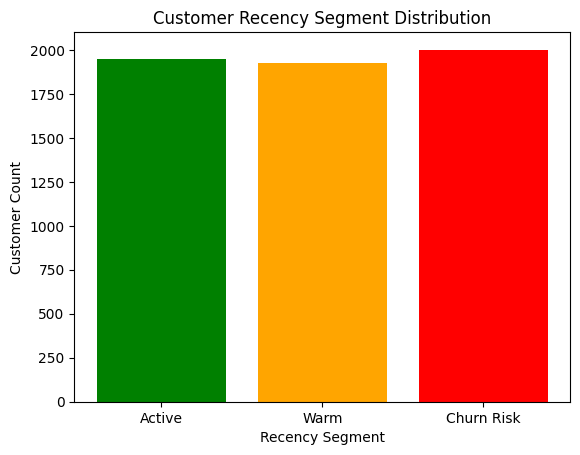

In [255]:
fig, ax = plt.subplots()
order = ["Active", "Warm", "Churn Risk"]

recency_plot = (
    customer_recency
    .reset_index()
    .set_index("Recency Segment")
    .reindex(order)
)

ax.bar(
    recency_plot.index,
    recency_plot["Customer Count"],
    color=["green", "orange", "red"]
)

ax.set_title("Customer Recency Segment Distribution")
ax.set_xlabel("Recency Segment")
ax.set_ylabel("Customer Count")

plt.show()

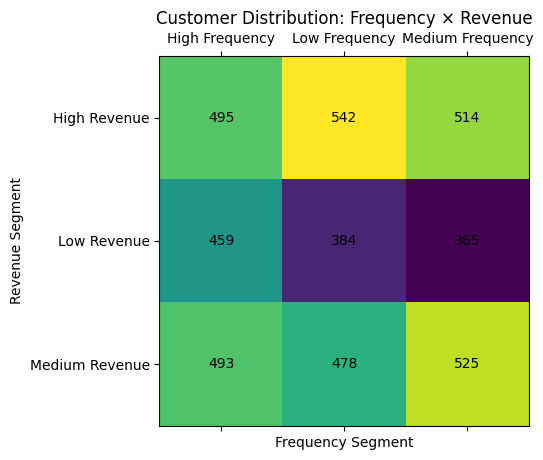

In [256]:
heatmap_data = (
    master_table
    .groupby(["Revenue Segment", "Frequency Segment"])
    .size()
    .unstack(fill_value=0)
)
fig, ax = plt.subplots()

cax = ax.matshow(heatmap_data)

ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns)

ax.set_yticks(range(len(heatmap_data.index)))
ax.set_yticklabels(heatmap_data.index)

ax.set_xlabel("Frequency Segment")
ax.set_ylabel("Revenue Segment")
ax.set_title("Customer Distribution: Frequency × Revenue")

for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        ax.text(
            j,
            i,
            heatmap_data.iloc[i, j],
            ha="center",
            va="center"
        )

plt.show()

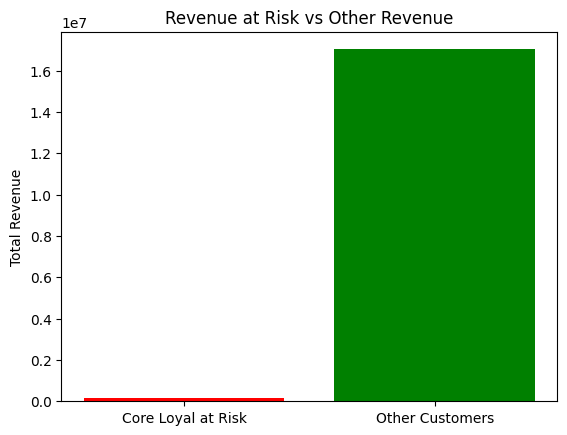

In [257]:
at_risk_revenue = losing_customers["Revenue"].sum()
total_revenue = master_table["Revenue"].sum()
other_revenue = total_revenue - at_risk_revenue

labels = ["Core Loyal at Risk", "Other Customers"]
values = [at_risk_revenue, other_revenue]

fig, ax = plt.subplots()

ax.bar(labels, values, color=["red", "green"])

ax.set_title("Revenue at Risk vs Other Revenue")
ax.set_ylabel("Total Revenue")

plt.show()